socket created 
socket binded to port 
socket listensing ... 

got connection from  ('127.0.0.1', 57479)
writing calibration data


<IPython.core.display.Javascript object>


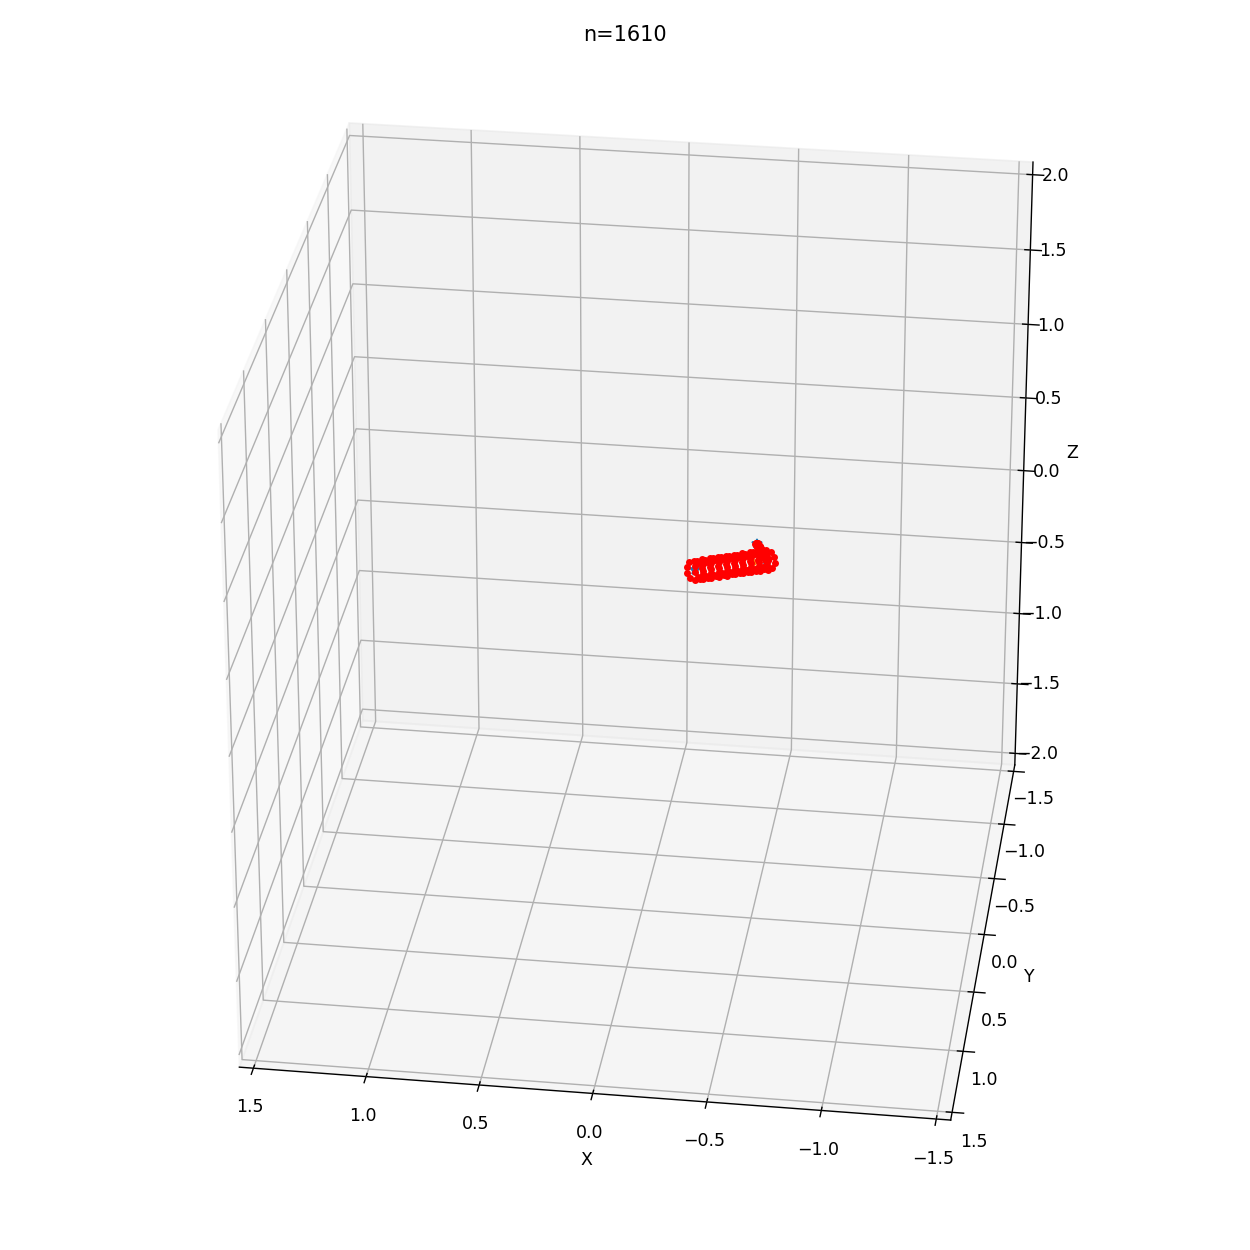

calib data_al 
right_track_ini [[ 0.83304 -0.53133  0.15405 -0.51331]
 [-0.06231 -0.36681 -0.92821  3.15781]
 [-0.54969 -0.76364  0.33868 -0.46896]
 [ 0.       0.       0.       1.     ]]
r track robot [[-0.54969    -0.76364     0.33868    -0.61896001]
 [ 0.83304    -0.53133     0.15405     0.28669001]
 [-0.06231    -0.36681    -0.92821     0.35781005]
 [ 0.          0.          0.          1.        ]]
left_track_ini [[-0.9222   0.37591  0.09076 -0.61743]
 [-0.0569   0.10023 -0.99334  3.09972]
 [ 0.3825   0.92122  0.07105 -0.63138]
 [ 0.       0.       0.       1.     ]]
l track_ [[ 0.3825      0.92122     0.07105    -0.78138001]
 [-0.9222      0.37591     0.09076     0.18257001]
 [-0.0569      0.10023    -0.99334     0.29972005]
 [ 0.          0.          0.          1.        ]]
waiting for press data


In [2]:
%matplotlib notebook

def update_points_realtime(num, cyl_u,cyl_f, l,points,left_track_new,right_track_ini):
 
    global radial_density,height_density,shoulder_in_right_tracker_CS, wrist_in_left_tracker_CS,elbow_in_left_tracker_CS  
    global forearm_radius, upper_arm_radius
    global tf2robot
    right_track_ini ,left_track_new = process_data()
    right_track_ini = tf2robot @ right_track_ini
    left_track_new = tf2robot @ left_track_new
    x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                   elbow_in_left_tracker_CS,
                   shoulder_in_right_tracker_CS,
                   left_track_new,
                   right_track_ini)
    txt.set_text('n={:d}'.format(num)) # for debug purposes
    points.set_data(x,y)
    points.set_3d_properties(z, 'z')
    
    l.set_data(np.array([right_track_ini[0,3],left_track_new[0,3]]),
               np.array([right_track_ini[1,3],left_track_new[1,3]]))
    l.set_3d_properties(np.array([right_track_ini[2,3],left_track_new[2,3]]), 'z')

    
    start_point_f = np.array([x[1],y[1],z[1]])
    end_point_f  = np.array([x[0],y[0],z[0]])
    point_on_cylinder_f = left_track_new[:3,3]
    
    start_point_u = np.array([x[2],y[2],z[2]])
    end_point_u  = np.array([x[1],y[1],z[1]])
    point_on_cylinder_u = right_track_ini[:3,3]

    xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,forearm_radius,radial_density,height_density)
    xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,upper_arm_radius,radial_density,height_density)
    
    cyl_f.set_data(xc_f,yc_f)
    cyl_f.set_3d_properties(zc_f, 'z')
    
    cyl_u.set_data(xc_u,yc_u)
    cyl_u.set_3d_properties(zc_u, 'z')
    
    return cyl_u,cyl_f,l,points,txt

# parsing tfs, switch to right-hand CS
#be carefull with the decode function
def process_data(calibration_stage = False):
    if (calibration_stage):
        #clear initial bullshit data
        for i in range(10):
            incoming_message = c.recv(1024).decode("utf-8")
        
    incoming_message = c.recv(1024).decode("utf-8") #Collect data from port and decode into  string
    data_start_ix = incoming_message.find("[")
    data_end_ix = incoming_message.find("]")
    data_found = (data_start_ix != -1) and (data_end_ix != -1) and (data_start_ix < data_end_ix)

    while(not data_found):
        incoming_message = c.recv(1024).decode("utf-8") #Collect data from port and decode into  string
#         print("data not found")
        data_start_ix = incoming_message.find("[")
        data_end_ix = incoming_message.find("]")
        data_found = (data_start_ix != -1) and  (data_end_ix != -1) and (data_start_ix < data_end_ix)
#         print("data_found",data_found)
#         print("data_start_ix,data_end_ix",data_start_ix,data_end_ix)
        
    incoming_message = incoming_message[data_start_ix+1 : data_end_ix] 
    incoming_message = incoming_message.replace(',','.')
    list_matrix = incoming_message.split(";")

    right_hand = to_right_CS(np.fromstring(list_matrix[0], dtype=np.float,sep =" ").reshape((4,4)))
    left_hand = to_right_CS(np.fromstring(list_matrix[1], dtype=np.float,sep =" ").reshape((4,4)))
    
    check_boolshit = np.linalg.norm(right_hand[:3,3]) > 0.01 and np.linalg.norm(left_hand[:3,3]) > 0.01
    if (not check_boolshit): print("boolshit check is not passed")
#     print("left hand tf")
#     print(left_hand) 
#     print("right_hand")
#     print(right_hand)
    return right_hand, left_hand
    
s = socket.socket()

print('socket created ')
port = 1234
s.bind(('127.0.0.1', port)) #bind port with ip address
print('socket binded to port ')
s.listen(5)#listening for connection
print('socket listensing ... ')

c, addr = s.accept() #when port connected
print("\ngot connection from ", addr)
print("writing calibration data")
keyboard.wait('esc')

fig = plt.figure(figsize=(10,10))
ax = p3.Axes3D(fig)

ax.set_xlim3d([-1.5, 1.5])
ax.set_xlabel('X')

ax.set_ylim3d([-1.5, 1.5])
ax.set_ylabel('Y')

ax.set_zlim3d([-2.0, 2.0])
ax.set_zlabel('Z')

right_track_ini,left_track_ini = process_data(True)
print("calib data_al ")
print("right_track_ini",right_track_ini)
print("r track robot", tf2robot @ right_track_ini)
print("left_track_ini", left_track_ini)
print("l track_",tf2robot @ left_track_ini)

dir_to_wrist_in_AL = get_direction_to_wrist_in_AL(left_track_ini,right_track_ini,forearm_radius,upper_arm_radius)
        
wrist_in_left_tracker_CS,elbow_in_left_tracker_CS = get_forearm_tfs(left_track_ini,
                                                                    dir_to_wrist_in_AL,
                                                                    length_l_wrist,
                                                                    length_l_elbow)

shoulder_in_right_tracker_CS =  get_upperarm_tf(right_track_ini,
                                                dir_to_wrist_in_AL,
                                                length_r_shoulder)

right_track_ini = tf2robot @ right_track_ini
left_track_ini = tf2robot @ left_track_ini

x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                     elbow_in_left_tracker_CS,
                   shoulder_in_right_tracker_CS,
                   left_track_ini,
                   right_track_ini)

points, = ax.plot(x, y, z, '*')
txt = fig.suptitle('')
l, = ax.plot(np.array([left_track_ini[0,3],right_track_ini[0,3]]),
             np.array([left_track_ini[1,3],right_track_ini[1,3]]),
             np.array([left_track_ini[2,3],right_track_ini[2,3]]), '.')

radial_density = 30
height_density = 30

start_point_f = np.array([x[1],y[1],z[1]])
end_point_f  = np.array([x[0],y[0],z[0]])

start_point_u = np.array([x[2],y[2],z[2]])
end_point_u  = np.array([x[1],y[1],z[1]])

xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,forearm_radius,radial_density,height_density)
xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,upper_arm_radius,radial_density,height_density)
cyl_f, = ax.plot(xc_f,yc_f ,zc_f, '.', color ='red')
cyl_u, = ax.plot(xc_u,yc_u ,zc_u, '.', color ='red')

print("waiting for press data")
keyboard.wait('esc')

# while True:
right_track_new ,left_track_new = process_data()

ani=animation.FuncAnimation(fig,
                    update_points_realtime,
                    save_count = 10,
                    fargs=(cyl_u,cyl_f,l,points,left_track_new,right_track_new))
plt.show()
# realtime update of points in 3D

In [1]:
# functions and constants initialization
import time, serial
import sys
import urx
import numpy as np
import keyboard
import json, math
from numpy.linalg import inv
import os
from scipy import stats
import  socket
from IPython.display import clear_output
from _thread import *
import threading


from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
from scipy.spatial.transform import Rotation as R

# constants initialization
# multiplication from left moves to robot cs
tf2robot = np.array([[0,0,1,-150/1000],[1,0,0,800/1000],[0,1,0,-2800/1000],[0,0,0,1]],dtype = np.float32)
tf2Antilat = np.linalg.inv(tf2robot)

#flips z coordinate to transform left-handed CS to the right-handed one
def to_right_CS (tf_in_left_cs):
    if tf_in_left_cs.shape != (4,4):
        raise
    tf_in_right_cs = tf_in_left_cs.copy()
    tf_in_right_cs[2,:] = -1 * tf_in_left_cs[2,:]
    
    return tf_in_right_cs

def get_direction_to_wrist_in_AL(left_track_ini_in_AL_CS,right_track_ini_in_AL_CS,forearm_radius,upper_arm_radius):
    
    dir_to_wrist_in_AL = np.array([0,0,0],dtype = np.float32)
    
    z_dir_forearm = left_track_ini_in_AL_CS[:3,2]
    z_shift_forearm_in_AL = - forearm_radius *  z_dir_forearm/np.linalg.norm(z_dir_forearm)
    
    z_dir_upperarm = right_track_ini_in_AL_CS [:3,2]
    z_shift_upperarm_in_AL = - upper_arm_radius *  z_dir_upperarm/np.linalg.norm(z_dir_upperarm)
    
#     center_of_forearm_in_AL_CS = np.array([0,0,0,1],dtype = np.float32)
    center_of_forearm_in_AL_CS = left_track_ini_in_AL_CS[:3,3] + z_shift_forearm_in_AL
    
#     center_of_forearm_in_CS =  np.linalg.inv(left_track_ini_in_AL_CS)

#     center_of_upperarm_in_AL_CS = np.array([0,0,0,1],dtype = np.float32)
    center_of_upperarm_in_AL_CS = right_track_ini_in_AL_CS[:3,3] + z_shift_upperarm_in_AL
    
#     center_of_upperarm_in_CS =  np.linalg.inv(center_of_upperarm_in_AL_CS)

#     center_of_upperarm_in_AL_CS = right_track_ini_in_AL_CS @ center_of_upperarm_in_AL_CS

    dir_to_wrist_in_AL = center_of_forearm_in_AL_CS - center_of_upperarm_in_AL_CS
    dir_to_wrist_in_AL = dir_to_wrist_in_AL/np.linalg.norm(dir_to_wrist_in_AL)
    
    return dir_to_wrist_in_AL

def get_forearm_tfs(left_track_ini_in_AL_CS,dir_to_wrist_in_AL,length_l_wrist,length_l_elbow):
    
    dir_to_elbow_in_AL = dir_to_wrist_in_AL.copy()
    dir_to_elbow_in_AL = -1 * dir_to_wrist_in_AL
    
    wrist_in_AL_CS = np.eye(4,dtype = np.float32)
    elbow_in_AL_CS = np.eye(4,dtype = np.float32)

    #z_axis is directed from the hand  
    wrist_in_AL_CS[:3,3] = left_track_ini_in_AL_CS[:3,3] + length_l_wrist * dir_to_wrist_in_AL
    elbow_in_AL_CS[:3,3] = left_track_ini_in_AL_CS[:3,3] + length_l_elbow * dir_to_elbow_in_AL
    wrist_in_left_tracker_CS = np.linalg.inv(left_track_ini_in_AL_CS) @ wrist_in_AL_CS
    elbow_in_left_tracker_CS = np.linalg.inv(left_track_ini_in_AL_CS) @ elbow_in_AL_CS
    
#     wrist_in_left_tracker_CS[:3,3] = wrist_in_left_tracker_CS[:3,3] + z_shift_in_forearm_CS
#     elbow_in_left_tracker_CS[:3,3] = elbow_in_left_tracker_CS[:3,3] + z_shift_in_forearm_CS
    
    return wrist_in_left_tracker_CS,elbow_in_left_tracker_CS

def get_upperarm_tf(right_track_ini_in_AL_CS,dir_to_wrist_in_AL, length_r_shoulder):
    
    dir_to_shoulder_in_AL = dir_to_wrist_in_AL.copy()
    dir_to_shoulder_in_AL = -1 * dir_to_wrist_in_AL

    shoulder_in_AL_CS = np.eye(4,dtype = np.float32)
    shoulder_in_AL_CS[:3,3] = right_track_ini_in_AL_CS[:3,3] + length_r_shoulder * dir_to_shoulder_in_AL 
   
    shoulder_in_right_tracker_CS = np.linalg.inv(right_track_ini_in_AL_CS) @ shoulder_in_AL_CS 
#     shoulder_in_right_tracker_CS[:3,3] = shoulder_in_right_tracker_CS[:3,3] + z_shift_upper_arm_CS
    
    return shoulder_in_right_tracker_CS

def calc_all_tfs(tf_2_wrist_in_forearm_CS,
                   tf_2_elbow_in_forearm_CS,
                   tf_2_shoulder_in_upperarm_CS,
                   left_hand_R,
                   right_hand_R):
    
    new_wrist = left_hand_R @ tf_2_wrist_in_forearm_CS
    new_elbow = left_hand_R @ tf_2_elbow_in_forearm_CS
    new_shoulder = right_hand_R @ tf_2_shoulder_in_upperarm_CS
    x_new = np.array([new_wrist[0,3],new_elbow[0,3],new_shoulder[0,3]]) 
    y_new = np.array([new_wrist[1,3],new_elbow[1,3],new_shoulder[1,3]]) 
    z_new = np.array([new_wrist[2,3],new_elbow[2,3],new_shoulder[2,3]]) 
    
    return x_new,y_new,z_new


# the distance from trackers to elbow, wrist,and shoulder
length_l_wrist = 350/1000 # mm
length_l_elbow = 80/1000 # mm
length_r_elbow = 100/1000
length_r_shoulder = 150/1000
#####
# estimated arm params
forearm_radius = 55/1000
upper_arm_radius = 60/1000
whrist_radius = 50/1000
shoulder_radius = 50/1000
#####
def cylinder_generation(start_point,end_point,radius,radial_density,height_density):
    dz =  (end_point - start_point)/ (height_density-1)
    dTheta = 2 * np.pi / radial_density
    dz_norm = dz / np.linalg.norm(dz)
    
    eps = 1e-3
    other_vector = dz + np.array([1.0,1.0, 1.0])
    check_collinearity = np.abs(np.linalg.norm(np.cross(dz,other_vector))) < eps 
    
    if (not check_collinearity): other_vector = dz + np.array([1.0,1.0, 1.0])
    vec_to_surface = np.cross(dz, other_vector - start_point)

    
    start_point_on_surface = vec_to_surface / (np.linalg.norm(vec_to_surface)) * radius
    rot_matrix = R.from_rotvec(dTheta * dz_norm).as_matrix()
    all_points = np.empty((radial_density * height_density,3))
    
    #generate points relative to the CS origin
    for i in range(height_density):
        all_points[i*radial_density,:] = start_point_on_surface
        for j in range(1,radial_density):
            start_point_on_surface = rot_matrix @ start_point_on_surface
            all_points[i*radial_density + j,:] = start_point_on_surface
        start_point_on_surface += dz
        
    #shift points to start point
    for point in all_points:
        point += start_point 
    
    return all_points[:,0],all_points[:,1],all_points[:,2]


In [ ]:
# realtime update of points in 3D
def get_test_vals():
    #setting calibrated poses
    xl,yl,zl = length_r_shoulder + length_l_elbow+length_r_elbow,0.0,0.0 #mm
    xr,yr,zr = length_r_shoulder, 0, 0 
    left_track_ini  = np.eye(4,dtype = np.float32)
    right_track_ini = np.eye(4,dtype = np.float32)
    left_track_ini[:3,3] = [xl,yl,zl] 
    right_track_ini[:3,3] = [xr,yr,zr]
    left_track_new = left_track_ini.copy()
    left_track_new[:3,3] = [xl-length_l_elbow ,yl + length_l_elbow,zl]
    left_track_new[:3,:3] = left_track_new[:3,:3] @ R.from_euler('z', 90, degrees=True).as_matrix()
    
    return left_track_ini,right_track_ini,left_track_new

def update_points(num, cyl_u,cyl_f, l,points,left_track_new,right_track_ini):
 
    global radial_density,height_density,shoulder_in_right_tracker_CS, wrist_in_left_tracker_CS,elbow_in_left_tracker_CS  
    global  forearm_radius, upper_arm_radius
    left_track_new = update(num,left_track_new)
    right_track_ini  = update(num,right_track_ini)
    x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                   elbow_in_left_tracker_CS,
                   shoulder_in_right_tracker_CS,
                   left_track_new,
                   right_track_ini)
    txt.set_text('n={:d}'.format(num)) # for debug purposes
    points.set_data(x,y)
    points.set_3d_properties(z, 'z')
    
    l.set_data(np.array([right_track_ini[0,3],left_track_new[0,3]]),
               np.array([right_track_ini[1,3],left_track_new[1,3]]))
    l.set_3d_properties(np.array([right_track_ini[2,3],left_track_new[2,3]]), 'z')

    
    start_point_f = np.array([x[1],y[1],z[1]])
    end_point_f  = np.array([x[0],y[0],z[0]])
    point_on_cylinder_f = left_track_new[:3,3]
    
    start_point_u = np.array([x[2],y[2],z[2]])
    end_point_u  = np.array([x[1],y[1],z[1]])
    point_on_cylinder_u = right_track_ini[:3,3]
    
    xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,forearm_radius,radial_density,height_density)
    xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,upper_arm_radius,radial_density,height_density)
    
    cyl_f.set_data(xc_f,yc_f)
    cyl_f.set_3d_properties(zc_f, 'z')
    
    cyl_u.set_data(xc_u,yc_u)
    cyl_u.set_3d_properties(zc_u, 'z')
    
    return cyl_u,cyl_f,l,points,txt

def update(num,input_tf):
    shift_tf,rot_tf,rot_tf_2 = np.eye(4,dtype=np.float32),np.eye(4,dtype=np.float32),np.eye(4,dtype=np.float32)
    shift_tf[:3,3] = [0.01*num,0*num,0.01*num]
    rot_tf[:3,:3] = R.from_euler('z', 5*num, degrees=True).as_matrix()
    rot_tf_2[:3,:3] = R.from_euler('y', 5*num, degrees=True).as_matrix()
    return shift_tf @ rot_tf @  rot_tf_2 @ input_tf

%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = p3.Axes3D(fig)

ax.set_xlim3d([-1.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([-1.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 1.5])
ax.set_zlabel('Z')

left_track_ini,right_track_ini,left_track_new = get_test_vals()

dir_to_wrist_in_AL = get_direction_to_wrist_in_AL(left_track_ini,right_track_ini,forearm_radius,upper_arm_radius)
        
wrist_in_left_tracker_CS,elbow_in_left_tracker_CS = get_forearm_tfs(left_track_ini,
                                                                    dir_to_wrist_in_AL,
                                                                    length_l_wrist,
                                                                    length_l_elbow)

shoulder_in_right_tracker_CS =  get_upperarm_tf(right_track_ini,
                                                dir_to_wrist_in_AL,
                                                length_r_shoulder)

x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                     elbow_in_left_tracker_CS,
                   shoulder_in_right_tracker_CS,
                   left_track_ini,
                   right_track_ini)

points, = ax.plot(x, y, z, '*')
txt = fig.suptitle('')
l, = ax.plot(np.array([left_track_ini[0,3],right_track_ini[0,3]]),
             np.array([left_track_ini[1,3],right_track_ini[1,3]]),
             np.array([left_track_ini[2,3],right_track_ini[2,3]]), '.')

radial_density = 10
height_density = 10
start_point_f = np.array([x[1],y[1],z[1]])
end_point_f  = np.array([x[0],y[0],z[0]])
point_on_cylinder_f = left_track_ini[:3,3]

start_point_u = np.array([x[2],y[2],z[2]])
end_point_u  = np.array([x[1],y[1],z[1]])
point_on_cylinder_u = right_track_ini[:3,3]

xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,forearm_radius,radial_density,height_density)
xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,upper_arm_radius,radial_density,height_density)
cyl_f, = ax.plot(xc_f,yc_f ,zc_f, '.', color ='red')
cyl_u, = ax.plot(xc_u,yc_u ,zc_u, '.', color ='red')

ani=animation.FuncAnimation(fig,
                            update_points,
                            frames=100,
                            fargs=(cyl_u,cyl_f,l,points,left_track_new,right_track_ini))

plt.show()

In [ ]:
#pipeline on a real setup

s = socket.socket()
print('socket created ')
port = 1234
s.bind(('127.0.0.1', port)) #bind port with ip address
print('socket binded to port ')
s.listen(5)#listening for connection
print('socket listensing ... ')

c, addr = s.accept() #when port connected
print("\ngot connection from ", addr)

print("writing calibration data")
right_hand_prev,left_hand_prev = processData()
keyboard.wait('esc')

wrist_in_left_tracker_CS,elbow_in_left_tracker_CS = get_forearm_tfs(left_track_ini,
                                                                    right_track_ini,
                                                                    length_l_wrist,
                                                                    length_l_elbow,
                                                                    forearm_radius)

shoulder_in_right_tracker_CS =  get_upperarm_tf(left_track_ini,
                                                right_track_ini,
                                                length_r_shoulder,
                                                upper_arm_radius)


while True:
        right_hand_new ,left_hand_new = processData()
        print("left hand tf")
        print(right_hand_new) 
        print("right_hand")
        print(left_hand_new)



In [ ]:
#test cyl generation

start_point = np.array([0,0,0])
end_point = np.array([0,1,0])
point_on_cylinder = np.array([0,0,1])
radial_density = 30
height_density = 10
x,y,z = cylinder_generation(start_point,end_point,point_on_cylinder,radial_density,height_density)

fig = plt.figure()
ax = p3.Axes3D(fig)
ax.set_xlim3d([-3.0, 3.0])
ax.set_xlabel('X')

ax.set_ylim3d([-2.0, 2.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 5.0])
ax.set_zlabel('Z')

plot_points, = ax.plot(x, y, z, '*')
plt.show()

In [ ]:
#something deprecated

def get_upperarm_tf(left_track_ini_in_AL_CS,
                    right_track_ini_in_AL_CS,length_r_shoulder,upper_arm_radius):
    
    dir_to_wrist_in_AL = np.array([0,0,0,1],dtype = np.float32)
    dir_to_wrist_in_AL[:3] = left_track_ini_in_AL_CS[:3,3] - right_track_ini_in_AL_CS[:3,3]
    dir_to_wrist_in_AL[:3] = dir_to_wrist_in_AL[:3]/np.linalg.norm(dir_to_wrist_in_AL[:3])
    
    dir_to_shoulder_in_AL = dir_to_wrist_in_AL.copy()
    dir_to_shoulder_in_AL[:3] = -1 * dir_to_wrist_in_AL[:3]

    z_shift_upper_arm_CS = np.array([0.0,0.0,-upper_arm_radius])
       
    shoulder_in_AL_CS = np.eye(4,dtype = np.float32)
    shoulder_in_AL_CS[:3,3] = right_track_ini_in_AL_CS[:3,3] + length_r_shoulder * dir_to_shoulder_in_AL[:3] 
   
    shoulder_in_right_tracker_CS = np.linalg.inv(right_track_ini_in_AL_CS) @ shoulder_in_AL_CS 
    shoulder_in_right_tracker_CS[:3,3] = shoulder_in_right_tracker_CS[:3,3] + z_shift_upper_arm_CS
    
    return shoulder_in_right_tracker_CS

In [ ]:
# parsing tfs, switch to right-hand CS
#be carefull with the decode function
import  socket
import numpy as np

#flips z coordinate to transform left-handed CS to the right-handed one
def to_right_CS (tf_in_left_cs):
    if tf_in_left_cs.shape != (4,4):
        raise
    tf_in_right_cs = tf_in_left_cs.copy()
    tf_in_right_cs[2,:] = -1 * tf_in_left_cs[2,:]
    
    return tf_in_right_cs

def process_data():
    incoming_message = c.recv(1024).decode("utf-8") #Collect data from port and decode into  string
    data_start_ix = incoming_message.find("[")
    data_end_ix = incoming_message.find("]")
    data_found = (data_start_ix != -1) and (data_end_ix != -1) and (data_start_ix < data_end_ix)

    while(not data_found):
        incoming_message = c.recv(1024).decode("utf-8") #Collect data from port and decode into  string
#         print("data not found")
        data_start_ix = incoming_message.find("[")
        data_end_ix = incoming_message.find("]")
        data_found = (data_start_ix != -1) and  (data_end_ix != -1) and (data_start_ix < data_end_ix)
#         print("data_found",data_found)
#         print("data_start_ix,data_end_ix",data_start_ix,data_end_ix)
        
    incoming_message = incoming_message[data_start_ix+1 : data_end_ix] 
    incoming_message = incoming_message.replace(',','.')
    list_matrix = incoming_message.split(";")

    right_hand = to_right_CS(np.fromstring(list_matrix[0], dtype=np.float,sep =" ").reshape((4,4)))
    left_hand = to_right_CS(np.fromstring(list_matrix[1], dtype=np.float,sep =" ").reshape((4,4)))
    
    check_boolshit = np.linalg.norm(right_hand[:3,3]) > 0.01 and np.linalg.norm(left_hand[:3,3]) > 0.01
    if (not check_boolshit): print("boolshit check is not passed")
#     print("left hand tf")
#     print(left_hand) 
#     print("right_hand")
#     print(right_hand)
    return right_hand, left_hand
    
s = socket.socket()

print('socket created ')
port = 1234
s.bind(('127.0.0.1', port)) #bind port with ip address
print('socket binded to port ')
s.listen(5)#listening for connection
print('socket listensing ... ')

c, addr = s.accept() #when port connected
print("\ngot connection from ", addr)
print("writing calibration data")
# keyboard.wait('esc')
while True:
    right_track_ini,left_track_ini = process_data()
    
    print("right_track_ini","\n",right_track_ini)
# print("r track robot", tf2robot @ right_track_ini)
    print("left_track_ini","\n", left_track_ini)
# print("l track_",tf2robot @ left_track_ini)

socket created 
socket binded to port 
socket listensing ... 

got connection from  ('127.0.0.1', 57360)
writing calibration data
right_track_ini 
 [[ 9.99990e-01 -4.29000e-03 -3.50000e-04 -1.40000e-04]
 [ 4.29000e-03  9.99990e-01 -2.08000e-03  2.18959e+00]
 [-3.60000e-04 -2.08000e-03 -1.00000e+00  2.10000e-04]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]
left_track_ini 
 [[ 9.99960e-01 -5.97000e-03  6.81000e-03  3.20000e-04]
 [ 5.98000e-03  9.99980e-01 -1.67000e-03  2.18944e+00]
 [ 6.80000e-03 -1.71000e-03 -9.99980e-01  5.40000e-04]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]
right_track_ini 
 [[ 1.00000e+00 -2.60000e-04 -4.00000e-05  0.00000e+00]
 [ 2.60000e-04  1.00000e+00 -1.30000e-04  2.18999e+00]
 [-4.00000e-05 -1.30000e-04 -1.00000e+00 -0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]
left_track_ini 
 [[ 9.9999e-01 -2.1800e-03  2.5100e-03  6.0000e-05]
 [ 2.1800e-03  1.0000e+00 -8.2000e-04  2.1899e+00]
 [ 2.5100e-03 -8.3000e-04 -1.0000e+

right_track_ini 
 [[ 0.4961   0.62736 -0.60025  0.     ]
 [-0.45333 -0.40246 -0.79531  3.87   ]
 [ 0.74052 -0.66667 -0.08475 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.70529 -0.48596  0.51614  0.     ]
 [ 0.47719 -0.21298 -0.8526   3.87   ]
 [-0.52426 -0.84763 -0.08168 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.4936   0.62989 -0.59966  0.     ]
 [-0.45267 -0.40267 -0.79558  3.87   ]
 [ 0.7426  -0.66415 -0.08637 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.70975 -0.48263  0.51315  0.     ]
 [ 0.47621 -0.20808 -0.85436  3.87   ]
 [-0.51911 -0.85075 -0.08215 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.49016  0.63254 -0.59969  0.     ]
 [-0.45303 -0.4029  -0.79526  3.87   ]
 [ 0.74465 -0.66149 -0.08908 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.71431 -0.4795   0.50975  0.     ]
 [ 0.47515 -0.20249 -0.85629  3.87   ]
 [-0.51381 -0.85386 -0.0832  -0.

 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.77233 -0.50384  0.38685  0.     ]
 [ 0.3681  -0.14133 -0.91898  3.87   ]
 [-0.51769 -0.85216 -0.07631 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.36952  0.62352 -0.68896  0.     ]
 [-0.36942 -0.58175 -0.72463  3.87   ]
 [ 0.85263 -0.52228 -0.01537 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.77399 -0.50398  0.38333  0.     ]
 [ 0.36092 -0.14628 -0.92105  3.87   ]
 [-0.52027 -0.85124 -0.06868 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.35375  0.62113 -0.69933  0.     ]
 [-0.35362 -0.60337 -0.71477  3.87   ]
 [ 0.86592 -0.50015 -0.0062  -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.77742 -0.50544  0.37436  0.     ]
 [ 0.34831 -0.14964 -0.92536  3.87   ]
 [-0.52374 -0.84978 -0.05971 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 3.3301e-01  6.1872e-01 -7.1154e-01  0.0000e+00]
 [-3.3404e-01 -6.28

right_track_ini 
 [[-0.16398  0.42336 -0.891    0.     ]
 [ 0.16224 -0.87935 -0.44768  3.87   ]
 [ 0.97303  0.21796 -0.07551 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.97238 -0.09849 -0.21162  0.     ]
 [-0.18936  0.19722 -0.9619   3.87   ]
 [-0.13647 -0.9754  -0.17312 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.15937  0.42565 -0.89074  0.     ]
 [ 0.16601 -0.87787 -0.4492   3.87   ]
 [ 0.97316  0.21946 -0.06924 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.97099 -0.10251 -0.21603  0.     ]
 [-0.19363  0.19305 -0.96189  3.87   ]
 [-0.14031 -0.97582 -0.1676  -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.15525  0.42648 -0.89108  0.     ]
 [ 0.16887 -0.87728 -0.44929  3.87   ]
 [ 0.97333  0.22023 -0.06418 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.97036 -0.10626 -0.21704  0.     ]
 [-0.19451  0.1895  -0.96242  3.87   ]
 [-0.1434  -0.97611 -0.16321 -0.

right_track_ini 
 [[-0.17515  0.41894 -0.89096  0.     ]
 [-0.01085 -0.90572 -0.42375  3.87   ]
 [ 0.98448  0.06456 -0.16318 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 9.9986e-01  1.9900e-03  1.6590e-02  0.0000e+00]
 [ 1.6580e-02  4.3200e-03 -9.9985e-01  3.8700e+00]
 [ 2.0600e-03 -9.9999e-01 -4.2900e-03 -0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00]]
right_track_ini 
 [[-0.17643  0.41992 -0.89024  0.     ]
 [-0.02465 -0.90603 -0.42248  3.87   ]
 [ 0.984    0.05259 -0.17021 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99948  0.01149  0.03028  0.     ]
 [ 0.03035 -0.00559 -0.99952  3.87   ]
 [ 0.01131 -0.99992  0.00593 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.17617  0.42069 -0.88994  0.     ]
 [-0.04792 -0.90667 -0.41911  3.87   ]
 [ 0.98319  0.03119 -0.17989 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99822  0.02744  0.05304  0.     ]
 [ 0.05366 -0.0222  -0.

right_track_ini 
 [[-0.15456  0.38682 -0.90911  0.     ]
 [-0.05899 -0.92214 -0.38233  3.87   ]
 [ 0.98622  0.00546 -0.16534 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99606  0.02159  0.08605  0.     ]
 [ 0.08774 -0.09603 -0.9915   3.87   ]
 [ 0.01315 -0.99514  0.09755 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.15487  0.38673 -0.9091   0.     ]
 [-0.05554 -0.92215 -0.38282  3.87   ]
 [ 0.98637  0.0088  -0.16429 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99635  0.01862  0.08336  0.     ]
 [ 0.08476 -0.09543 -0.99182  3.87   ]
 [ 0.01051 -0.99526  0.09666 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.15467  0.38638 -0.90928  0.     ]
 [-0.0521  -0.92226 -0.38303  3.87   ]
 [ 0.98659  0.01187 -0.16278 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99656  0.01647  0.08122  0.     ]
 [ 0.08242 -0.09462 -0.9921   3.87   ]
 [ 0.00865 -0.99538  0.09565 -0.

right_track_ini 
 [[-0.17083  0.37289 -0.91202  0.     ]
 [-0.02792 -0.92708 -0.37382  3.87   ]
 [ 0.9849   0.0384  -0.16879 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99751  0.01196  0.06954  0.     ]
 [ 0.07035 -0.09255 -0.99322  3.87   ]
 [ 0.00544 -0.99564  0.09316 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.16951  0.37176 -0.91272  0.     ]
 [-0.02439 -0.92742 -0.37322  3.87   ]
 [ 0.98523  0.041   -0.16627 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99782  0.00985  0.06529  0.     ]
 [ 0.06591 -0.09063 -0.9937   3.87   ]
 [ 0.00388 -0.99584  0.09109 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.169    0.37053 -0.91332  0.     ]
 [-0.02098 -0.92779 -0.37251  3.87   ]
 [ 0.98539  0.04379 -0.16457 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 9.9805e-01  7.6200e-03  6.1890e-02  0.0000e+00]
 [ 6.2320e-02 -8.8230e-02 -9.9415e-01  3.8700e+00]
 [ 2.110

right_track_ini 
 [[-1.5931e-01  3.6232e-01 -9.1834e-01  0.0000e+00]
 [-2.5100e-03 -9.3037e-01 -3.6663e-01  3.8700e+00]
 [ 9.8722e-01  5.6100e-02 -1.4913e-01 -0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00]]
left_track_ini 
 [[ 0.99904 -0.00508  0.04353  0.     ]
 [ 0.04303 -0.07456 -0.99629  3.87   ]
 [-0.00831 -0.9972   0.07427 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-1.5957e-01  3.6255e-01 -9.1820e-01  0.0000e+00]
 [-2.8400e-03 -9.3028e-01 -3.6683e-01  3.8700e+00]
 [ 9.8718e-01  5.5930e-02 -1.4948e-01 -0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00]]
left_track_ini 
 [[ 0.99903 -0.00491  0.04369  0.     ]
 [ 0.04319 -0.07634 -0.99615  3.87   ]
 [-0.00823 -0.99707  0.07605 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-1.6000e-01  3.6281e-01 -9.1803e-01  0.0000e+00]
 [-3.2200e-03 -9.3019e-01 -3.6705e-01  3.8700e+00]
 [ 9.8711e-01  5.5780e-02 -1.5000e-01 -0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+

right_track_ini 
 [[-0.16932  0.35462 -0.91955  0.     ]
 [ 0.00839 -0.93247 -0.36115  3.87   ]
 [ 0.98553  0.06886 -0.15491 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99917 -0.00448  0.04046  0.     ]
 [ 0.04005 -0.06868 -0.99683  3.87   ]
 [-0.00725 -0.99763  0.06844 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.17276  0.35518 -0.9187   0.     ]
 [ 0.01068 -0.93199 -0.36232  3.87   ]
 [ 0.98491  0.0724  -0.15722 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 9.9933e-01 -2.4800e-03  3.6650e-02  0.0000e+00]
 [ 3.6370e-02 -7.3250e-02 -9.9665e-01  3.8700e+00]
 [-5.1500e-03 -9.9731e-01  7.3110e-02 -0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00]]
right_track_ini 
 [[-0.17635  0.35496 -0.9181   0.     ]
 [ 0.014   -0.93172 -0.36291  3.87   ]
 [ 0.98423  0.07685 -0.15934 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 9.9948e-01 -2.3500e-03  3.2030e-02  0.0000e+00]
 [ 3.1750e-

right_track_ini 
 [[-0.17477  0.34106 -0.92365  0.     ]
 [ 0.05857 -0.93283 -0.35553  3.87   ]
 [ 0.98287  0.11623 -0.14306 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 9.9972e-01 -2.3770e-02  8.0000e-05  0.0000e+00]
 [-1.4800e-03 -6.5780e-02 -9.9783e-01  3.8700e+00]
 [-2.3730e-02 -9.9755e-01  6.5790e-02 -0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00]]
right_track_ini 
 [[-0.17568  0.34102 -0.92349  0.     ]
 [ 0.05757 -0.93292 -0.35546  3.87   ]
 [ 0.98276  0.11561 -0.14426 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 9.9974e-01 -2.2790e-02  1.8800e-03  0.0000e+00]
 [ 3.4000e-04 -6.7200e-02 -9.9774e-01  3.8700e+00]
 [-2.2860e-02 -9.9748e-01  6.7170e-02 -0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00]]
right_track_ini 
 [[-0.17658  0.34081 -0.9234   0.     ]
 [ 0.05692 -0.93304 -0.35525  3.87   ]
 [ 0.98264  0.11529 -0.14536 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 9.9975e-01 

right_track_ini 
 [[-0.19162  0.33232 -0.9235   0.     ]
 [ 0.06505 -0.93456 -0.3498   3.87   ]
 [ 0.97931  0.1271  -0.15746 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99983 -0.01663  0.0085   0.     ]
 [ 0.00732 -0.06994 -0.99752  3.87   ]
 [-0.01718 -0.99741  0.06981 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.19186  0.33165 -0.92369  0.     ]
 [ 0.0658  -0.93471 -0.34928  3.87   ]
 [ 0.97921  0.12779 -0.15751 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99981 -0.01714  0.00958  0.     ]
 [ 0.00837 -0.06957 -0.99754  3.87   ]
 [-0.01777 -0.99743  0.06942 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.19247  0.33157 -0.92359  0.     ]
 [ 0.06515 -0.93479 -0.34917  3.87   ]
 [ 0.97914  0.12738 -0.15832 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99984 -0.01527  0.00938  0.     ]
 [ 0.00831 -0.0684  -0.99762  3.87   ]
 [-0.01587 -0.99754  0.06826 -0.

right_track_ini 
 [[-0.18558  0.32836 -0.92614  0.     ]
 [ 0.07308 -0.93529 -0.34625  3.87   ]
 [ 0.97991  0.13194 -0.14957 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99938 -0.03433  0.00777  0.     ]
 [ 0.00558 -0.06333 -0.99798  3.87   ]
 [-0.03475 -0.9974   0.0631  -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.186    0.32909 -0.9258   0.     ]
 [ 0.07492 -0.93475 -0.34732  3.87   ]
 [ 0.97969  0.13396 -0.14921 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 9.9930e-01 -3.6920e-02  5.2000e-03  0.0000e+00]
 [ 2.7400e-03 -6.6220e-02 -9.9780e-01  3.8700e+00]
 [-3.7180e-02 -9.9712e-01  6.6070e-02 -0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00]]
right_track_ini 
 [[-0.18544  0.33004 -0.92557  0.     ]
 [ 0.07775 -0.93403 -0.34863  3.87   ]
 [ 0.97957  0.13661 -0.14755 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 9.9915e-01 -4.1180e-02  2.4500e-03  0.0000e+00]
 [-4.6000e-

right_track_ini 
 [[-0.19089  0.35536 -0.91503  0.     ]
 [ 0.13967 -0.91285 -0.38365  3.87   ]
 [ 0.97163  0.20104 -0.12462 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99607 -0.03236 -0.0825   0.     ]
 [-0.0851  -0.08965 -0.99233  3.87   ]
 [-0.02471 -0.99545  0.09205 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.19039  0.35557 -0.91505  0.     ]
 [ 0.13928 -0.91289 -0.3837   3.87   ]
 [ 0.97178  0.2005  -0.12428 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99608 -0.03249 -0.08231  0.     ]
 [-0.08495 -0.09057 -0.99226  3.87   ]
 [-0.02478 -0.99536  0.09298 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.1898   0.35623 -0.91492  0.     ]
 [ 0.13826 -0.91288 -0.38411  3.87   ]
 [ 0.97204  0.1994  -0.12401 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99614 -0.03266 -0.08144  0.     ]
 [-0.08415 -0.09232 -0.99217  3.87   ]
 [-0.02489 -0.99519  0.09471 -0.

 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99706 -0.03013 -0.07042  0.     ]
 [-0.07307 -0.09875 -0.99243  3.87   ]
 [-0.02295 -0.99466  0.10066 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.1889   0.36123 -0.91314  0.     ]
 [ 0.12754 -0.91298 -0.38755  3.87   ]
 [ 0.97368  0.18967 -0.12639 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99713 -0.0298  -0.06955  0.     ]
 [-0.07216 -0.09821 -0.99255  3.87   ]
 [-0.02274 -0.99472  0.10008 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.18939  0.36085 -0.91319  0.     ]
 [ 0.12717 -0.91318 -0.38721  3.87   ]
 [ 0.97363  0.18947 -0.12705 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99717 -0.02973 -0.06902  0.     ]
 [-0.07162 -0.09744 -0.99266  3.87   ]
 [-0.02279 -0.9948   0.09929 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.18932  0.36028 -0.91343  0.     ]
 [ 0.12699 -0.91346 -0.38661  3

right_track_ini 
 [[-0.19056  0.35675 -0.91456  0.     ]
 [ 0.1299  -0.91427 -0.38371  3.87   ]
 [ 0.97304  0.19191 -0.12788 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99716 -0.0297  -0.06914  0.     ]
 [-0.07161 -0.09199 -0.99318  3.87   ]
 [-0.02314 -0.99532  0.09385 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.19059  0.35665 -0.91459  0.     ]
 [ 0.12989 -0.91432 -0.38361  3.87   ]
 [ 0.97304  0.1919  -0.12793 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99717 -0.02963 -0.06907  0.     ]
 [-0.07153 -0.09191 -0.99319  3.87   ]
 [-0.02307 -0.99533  0.09377 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.19044  0.35657 -0.91465  0.     ]
 [ 0.12976 -0.91439 -0.38348  3.87   ]
 [ 0.97308  0.19172 -0.12787 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99718 -0.02949 -0.06908  0.     ]
 [-0.07152 -0.09182 -0.9932   3.87   ]
 [-0.02294 -0.99534  0.09367 -0.

right_track_ini 
 [[-0.1894   0.35191 -0.91667  0.     ]
 [ 0.13217 -0.91594 -0.37893  3.87   ]
 [ 0.97296  0.19293 -0.12696 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99713 -0.02955 -0.06969  0.     ]
 [-0.07204 -0.08779 -0.99353  3.87   ]
 [-0.02325 -0.9957   0.08966 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.18929  0.35182 -0.91673  0.     ]
 [ 0.13215 -0.91599 -0.37882  3.87   ]
 [ 0.97299  0.19285 -0.1269  -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99714 -0.02974 -0.06947  0.     ]
 [-0.07184 -0.08755 -0.99357  3.87   ]
 [-0.02347 -0.99572  0.08944 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.18914  0.35171 -0.9168   0.     ]
 [ 0.13212 -0.91605 -0.37868  3.87   ]
 [ 0.97302  0.19276 -0.1268  -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99714 -0.03006 -0.06935  0.     ]
 [-0.07174 -0.08748 -0.99358  3.87   ]
 [-0.0238  -0.99571  0.08938 -0.

right_track_ini 
 [[-0.23169  0.37271 -0.89856  0.     ]
 [ 0.01314 -0.92241 -0.38599  3.87   ]
 [ 0.9727   0.10124 -0.20881 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99755 -0.02253  0.06626  0.     ]
 [ 0.06284 -0.12851 -0.98972  3.87   ]
 [-0.03082 -0.99145  0.12678 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.21447  0.38439 -0.89791  0.     ]
 [-0.01165 -0.92025 -0.39117  3.87   ]
 [ 0.97666  0.07344 -0.20185 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99542 -0.03045  0.09061  0.     ]
 [ 0.08537 -0.14303 -0.98603  3.87   ]
 [-0.04299 -0.98925  0.13978 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.19212  0.39856 -0.8968   0.     ]
 [-0.03674 -0.9161  -0.39927  3.87   ]
 [ 0.98068  0.04376 -0.19065 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.99225 -0.04281  0.11665  0.     ]
 [ 0.10834 -0.16158 -0.98089  3.87   ]
 [-0.06084 -0.98593  0.15569 -0.

right_track_ini 
 [[ 0.39002  0.62991 -0.67164  0.     ]
 [-0.50709 -0.4619  -0.72767  3.87   ]
 [ 0.7686  -0.62439 -0.13927 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.6725  -0.2133   0.70869  0.     ]
 [ 0.73563  0.08758 -0.6717   3.87   ]
 [-0.08121 -0.97305 -0.21581 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.39463  0.62324 -0.67516  0.     ]
 [-0.51435 -0.45905 -0.72438  3.87   ]
 [ 0.76139 -0.63313 -0.13941 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.66014 -0.21682  0.71917  0.     ]
 [ 0.7471   0.0903  -0.65855  3.87   ]
 [-0.07785 -0.97203 -0.22159 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.39903  0.61555 -0.67961  0.     ]
 [-0.52349 -0.45558 -0.72     3.87   ]
 [ 0.75282 -0.64307 -0.14045 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.64587 -0.22054  0.7309   0.     ]
 [ 0.75989  0.09341 -0.64331  3.87   ]
 [-0.0736  -0.9709  -0.22791 -0.

right_track_ini 
 [[ 0.41119  0.51764 -0.75031  0.     ]
 [-0.61189 -0.45336 -0.64811  3.87   ]
 [ 0.67565 -0.72561 -0.13032 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.56041 -0.30269  0.77092  0.     ]
 [ 0.82159  0.08573 -0.56359  3.87   ]
 [-0.1045  -0.94923 -0.29673 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.40627  0.51426 -0.7553   0.     ]
 [-0.61866 -0.45351 -0.64156  3.87   ]
 [ 0.67246 -0.72792 -0.1339  -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.55315 -0.30113  0.77675  0.     ]
 [ 0.82676  0.08382 -0.55627  3.87   ]
 [-0.1024  -0.94989 -0.29532 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.40262  0.51114 -0.75936  0.     ]
 [-0.62475 -0.45287 -0.63608  3.87   ]
 [ 0.66902 -0.73051 -0.137   -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.54595 -0.2999   0.7823   0.     ]
 [ 0.83184  0.08273 -0.54881  3.87   ]
 [-0.09987 -0.95038 -0.29464 -0.

right_track_ini 
 [[ 0.1441   0.53126 -0.83486  0.     ]
 [-0.77919 -0.45915 -0.42667  3.87   ]
 [ 0.61    -0.712   -0.34779 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.40124 -0.00927  0.91593  0.     ]
 [ 0.90446 -0.15402 -0.39777  3.87   ]
 [-0.14476 -0.98802  0.05342 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.10564  0.54485 -0.83186  0.     ]
 [-0.79    -0.46208 -0.40297  3.87   ]
 [ 0.60394 -0.69974 -0.38162 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.39138  0.05278  0.91871  0.     ]
 [ 0.90831 -0.18232 -0.37647  3.87   ]
 [-0.14763 -0.98182  0.11929 -0.     ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.07976  0.55496 -0.82805  0.     ]
 [-0.79608 -0.46448 -0.38798  3.87   ]
 [ 0.59992 -0.69013 -0.40474 -0.     ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.3902   0.08623  0.91668  0.     ]
 [ 0.90844 -0.1982  -0.36805  3.87   ]
 [-0.14995 -0.97636  0.15567 -0.

right_track_ini 
 [[ 0.49568 -0.54903  0.67296 -0.73759]
 [-0.28882 -0.83495 -0.46845  3.20333]
 [-0.81907 -0.03783  0.57244 -0.39117]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.24527  0.95237 -0.18123 -0.91527]
 [ 0.51069 -0.03197 -0.85917  3.08474]
 [ 0.82404  0.30328  0.47852 -0.42054]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.5317  -0.55091  0.64327 -0.73037]
 [-0.25637 -0.82859 -0.49771  3.20189]
 [-0.8072  -0.09972  0.5818  -0.39157]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.30832  0.93744 -0.1617  -0.90527]
 [ 0.4725   0.00339 -0.88132  3.08087]
 [ 0.82564  0.34813  0.44399 -0.43513]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.56816 -0.55094  0.61128 -0.7226 ]
 [-0.22112 -0.81771 -0.53147  3.20047]
 [-0.79266 -0.16679  0.58641 -0.39217]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.37236  0.91835 -0.13411 -0.89373]
 [ 0.42789  0.04165 -0.90287  3.07734]
 [ 0.82356  0.39358  0.40846 -0.

right_track_ini 
 [[ 0.97424  0.19317  0.11637 -0.46411]
 [ 0.19261 -0.4443  -0.87493  3.22419]
 [ 0.11731 -0.8748   0.47006 -0.41971]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.99289 -0.10619  0.05378 -0.43407]
 [-0.05702  0.02768 -0.99799  3.15924]
 [-0.10449  0.99396  0.03354 -0.61858]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.97121  0.21025  0.11202 -0.45023]
 [ 0.19557 -0.43513 -0.87887  3.22104]
 [ 0.13604 -0.87547  0.46372 -0.42181]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.99042 -0.12863  0.05025 -0.41683]
 [-0.05252  0.0143  -0.99852  3.1579 ]
 [-0.12772  0.99159  0.02092 -0.62006]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.96805  0.22895  0.10231 -0.43703]
 [ 0.19483 -0.42982 -0.88164  3.21787]
 [ 0.15788 -0.87341  0.46069 -0.42258]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.98725 -0.15278  0.04476 -0.39953]
 [-0.04611  0.0053  -0.99892  3.15505]
 [-0.15238  0.98825  0.01228 -0.

 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.88552 -0.45066 -0.11294 -0.24304]
 [ 0.05162  0.14615 -0.98791  3.0847 ]
 [-0.46172  0.88065  0.10616 -0.5582 ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.91824  0.38604 -0.08837 -0.32126]
 [ 0.11647 -0.47651 -0.87142  3.16296]
 [ 0.37851 -0.78988  0.48252 -0.38041]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.87804 -0.46231 -0.12379 -0.24014]
 [ 0.06004  0.15019 -0.98683  3.08464]
 [-0.47481  0.87391  0.10412 -0.55663]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.91556  0.39042 -0.09657 -0.31963]
 [ 0.11073 -0.47555 -0.87269  3.16307]
 [ 0.38665 -0.78831  0.47862 -0.37958]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.87083 -0.47312 -0.1335  -0.2372 ]
 [ 0.06766  0.15364 -0.98581  3.08476]
 [-0.48691  0.8675   0.10178 -0.555  ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.91329  0.39413 -0.10273 -0.31809]
 [ 0.10643 -0.47439 -0.87386  3

right_track_ini 
 [[ 0.89613  0.41999 -0.14336 -0.28894]
 [ 0.07641 -0.46423 -0.88241  3.16201]
 [ 0.43716 -0.77981  0.4481  -0.37264]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.8418  -0.51537 -0.16051 -0.19931]
 [ 0.11126  0.1253  -0.98586  3.08698]
 [-0.52819  0.84776  0.04814 -0.54806]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.8971   0.41797 -0.14327 -0.28896]
 [ 0.07545 -0.4644  -0.88241  3.16189]
 [ 0.43535 -0.78079  0.44814 -0.37279]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.8429  -0.51336 -0.16117 -0.19971]
 [ 0.11261  0.12459 -0.9858   3.0869 ]
 [-0.52615  0.84908  0.04721 -0.54853]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.89786  0.41643 -0.14297 -0.28905]
 [ 0.07485 -0.46437 -0.88247  3.16177]
 [ 0.43388 -0.78163  0.44811 -0.37302]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.84405 -0.51151 -0.16102 -0.20007]
 [ 0.11288  0.12407 -0.98583  3.08671]
 [-0.52424  0.85027  0.04698 -0.

right_track_ini 
 [[ 0.92018  0.37936 -0.09669 -0.29633]
 [ 0.10228 -0.47136 -0.87599  3.1607 ]
 [ 0.37789 -0.79618  0.47253 -0.377  ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.89598 -0.4327  -0.1     -0.21626]
 [ 0.05749  0.11027 -0.99224  3.08528]
 [-0.44036  0.89477  0.07392 -0.55766]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.92036  0.3792  -0.09565 -0.29639]
 [ 0.10298 -0.47093 -0.87614  3.16086]
 [ 0.37728 -0.79651  0.47247 -0.37703]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.89609 -0.43253 -0.09966 -0.21638]
 [ 0.05728  0.10996 -0.99228  3.08554]
 [-0.44016  0.89489  0.07376 -0.55766]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.92053  0.37901 -0.09472 -0.29647]
 [ 0.10358 -0.47055 -0.87627  3.16106]
 [ 0.37669 -0.79683  0.47241 -0.3771 ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.89619 -0.43238 -0.0994  -0.21658]
 [ 0.05714  0.10971 -0.99232  3.08576]
 [-0.43997  0.89499  0.07362 -0.

right_track_ini 
 [[ 0.92024  0.38157 -0.08694 -0.29656]
 [ 0.11066 -0.4668  -0.87741  3.16345]
 [ 0.37538 -0.79781  0.47179 -0.37496]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.89725 -0.43208 -0.09078 -0.21603]
 [ 0.04772  0.10951 -0.99284  3.0883 ]
 [-0.43893  0.89516  0.07764 -0.55532]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.92009  0.38195 -0.08687 -0.29642]
 [ 0.11102 -0.46697 -0.87728  3.16343]
 [ 0.37564 -0.79753  0.47206 -0.37488]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.89702 -0.43255 -0.09084 -0.21586]
 [ 0.04768  0.10962 -0.99283  3.08823]
 [-0.43941  0.89492  0.07771 -0.55517]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.91999  0.38226 -0.08658 -0.29633]
 [ 0.11146 -0.46694 -0.87724  3.16323]
 [ 0.37576 -0.7974   0.47219 -0.3747 ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.89686 -0.43291 -0.09074 -0.2157 ]
 [ 0.04752  0.10967 -0.99283  3.08817]
 [-0.43975  0.89474  0.07778 -0.

right_track_ini 
 [[ 0.91766  0.38919 -0.08021 -0.29613]
 [ 0.12124 -0.46645 -0.8762   3.16431]
 [ 0.37842 -0.79433  0.47523 -0.37289]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.89591 -0.4368  -0.08093 -0.2143 ]
 [ 0.0362   0.10979 -0.9933   3.08915]
 [-0.44276  0.89283  0.08255 -0.55244]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.91793  0.38845 -0.08063 -0.29641]
 [ 0.12058 -0.46679 -0.87611  3.16421]
 [ 0.37797 -0.79449  0.47532 -0.37299]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.89598 -0.43663 -0.08113 -0.21478]
 [ 0.03617  0.11032 -0.99324  3.08916]
 [-0.44263  0.89285  0.08305 -0.55259]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.91843  0.38661 -0.0838  -0.297  ]
 [ 0.11659 -0.46697 -0.87656  3.16413]
 [ 0.37801 -0.79528  0.47395 -0.37335]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.89592 -0.43643 -0.08285 -0.21572]
 [ 0.03722  0.11209 -0.993    3.08914]
 [-0.44266  0.89273  0.08418 -0.

right_track_ini 
 [[ 0.98775 -0.12982 -0.08656 -0.37523]
 [-0.13716 -0.45798 -0.87832  3.15128]
 [-0.07438 -0.87943  0.47017 -0.41694]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.95988  0.04457 -0.27686 -0.40564]
 [ 0.27949  0.07166 -0.95747  3.08457]
 [ 0.02284  0.99643  0.08124 -0.61234]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.9835  -0.16283 -0.07882 -0.38068]
 [-0.14576 -0.45523 -0.87836  3.15075]
 [-0.10714 -0.87536  0.47145 -0.41831]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.95566  0.07646 -0.28439 -0.41831]
 [ 0.28947  0.06636 -0.95489  3.085  ]
 [ 0.05414  0.99486  0.08555 -0.61256]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.9784  -0.19381 -0.07193 -0.38523]
 [-0.15425 -0.45279 -0.87817  3.15052]
 [-0.13763 -0.8703   0.47291 -0.41934]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.94994  0.10683 -0.29359 -0.43019]
 [ 0.30098  0.06092 -0.95168  3.08536]
 [ 0.08378  0.99241  0.09003 -0.

right_track_ini 
 [[ 0.24022 -0.94464  0.22348 -0.54227]
 [-0.28007 -0.28788 -0.9158   3.18386]
 [-0.92944 -0.15741  0.33372 -0.35354]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.26467  0.92725 -0.26487 -0.75849]
 [ 0.43358 -0.13091 -0.89155  3.15108]
 [ 0.86137  0.35081  0.36739 -0.4144 ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.2218  -0.94839  0.22662 -0.54282]
 [-0.2828  -0.28499 -0.91586  3.18526]
 [-0.93318 -0.13905  0.33141 -0.35108]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.24457  0.93378 -0.26122 -0.76115]
 [ 0.43362 -0.13563 -0.89083  3.15242]
 [ 0.86727  0.33114  0.37174 -0.40759]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.20278 -0.95177  0.23025 -0.54435]
 [-0.28497 -0.28232 -0.91602  3.1869 ]
 [-0.93684 -0.12013  0.32847 -0.3478 ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.22341  0.94059 -0.25569 -0.76404]
 [ 0.43011 -0.14028 -0.89181  3.15387]
 [ 0.8747   0.30921  0.37322 -0.

right_track_ini 
 [[-0.22476 -0.90512  0.3609  -0.55427]
 [-0.33052 -0.2776  -0.90205  3.21278]
 [-0.91665  0.32203  0.23676 -0.28735]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.25574  0.9604  -0.1106  -0.78844]
 [ 0.41057 -0.21147 -0.88697  3.17025]
 [ 0.87523 -0.18143  0.44839 -0.21631]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.2277  -0.90296  0.36444 -0.55479]
 [-0.32931 -0.2808  -0.9015   3.21223]
 [-0.91635  0.32529  0.23342 -0.286  ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.26243  0.95872 -0.10951 -0.78847]
 [ 0.40808 -0.21311 -0.88773  3.16956]
 [ 0.87442 -0.18828  0.44716 -0.21424]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.22973 -0.90082  0.36845 -0.55542]
 [-0.32724 -0.28504 -0.90093  3.21148]
 [-0.91659  0.32755  0.2293  -0.28455]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.26938  0.95692 -0.10834 -0.78867]
 [ 0.40438 -0.2145  -0.88908  3.16874]
 [ 0.87402 -0.19569  0.44474 -0.

right_track_ini 
 [[-0.03107 -0.95106  0.30745 -0.55438]
 [-0.2528  -0.29012 -0.923    3.20703]
 [-0.96702  0.1064   0.23141 -0.32372]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.08599  0.97574 -0.20132 -0.79614]
 [ 0.30395 -0.21812 -0.92738  3.16078]
 [ 0.9488  -0.01855  0.31533 -0.29809]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[-0.01503 -0.95342  0.30127 -0.55344]
 [-0.25369 -0.28781 -0.92347  3.20736]
 [-0.96717  0.09031  0.23755 -0.32774]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 6.95000e-02  9.75840e-01 -2.07120e-01 -7.95780e-01]
 [ 3.02550e-01 -2.18460e-01 -9.27760e-01  3.16084e+00]
 [ 9.50600e-01 -1.82000e-03  3.10430e-01 -3.05200e-01]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]
right_track_ini 
 [[ 0.00378 -0.9556   0.29464 -0.55255]
 [-0.25395 -0.2859  -0.924    3.20737]
 [-0.96721  0.07133  0.24376 -0.33172]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[ 0.04991  0.97552 -0.21416 -0.79505]
 [ 0.30

right_track_ini 
 [[ 0.42628 -0.88702  0.17744 -0.52464]
 [-0.20393 -0.28534 -0.93648  3.17202]
 [-0.8813  -0.36302  0.30253 -0.38065]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.37373  0.86372 -0.3381  -0.72709]
 [ 0.30363 -0.2305  -0.92449  3.15434]
 [ 0.87643  0.44817  0.17611 -0.48294]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.44397 -0.87931  0.17234 -0.52173]
 [-0.20303 -0.28606 -0.93646  3.17138]
 [-0.87274 -0.38077  0.30552 -0.38322]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.39118  0.85442 -0.34198 -0.72241]
 [ 0.30398 -0.23078 -0.9243   3.15361]
 [ 0.86866  0.46552  0.16945 -0.48917]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.46282 -0.87042  0.16781 -0.51895]
 [-0.20075 -0.2873  -0.93657  3.17049]
 [-0.86342 -0.39977  0.30771 -0.38574]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.40901  0.84472 -0.3452  -0.71726]
 [ 0.30363 -0.23076 -0.92442  3.15285]
 [ 0.86053  0.48291  0.1621  -0.

right_track_ini 
 [[ 0.96574  0.08484 -0.24526 -0.31314]
 [-0.21085 -0.29446 -0.93211  3.18096]
 [ 0.1513  -0.95189  0.26649 -0.40487]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.8753  -0.2817  -0.39306 -0.28943]
 [ 0.45559 -0.20786 -0.86558  3.15979]
 [-0.16213  0.93672 -0.31028 -0.61366]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.96234  0.10697 -0.2499  -0.30777]
 [-0.21013 -0.29047 -0.93353  3.18179]
 [ 0.17245 -0.95089  0.25706 -0.40423]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.87018 -0.30538 -0.38668 -0.27868]
 [ 0.45786 -0.21119 -0.86357  3.16131]
 [-0.18205  0.92852 -0.3236  -0.61291]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.95864  0.12635 -0.25505 -0.30306]
 [-0.21087 -0.28659 -0.93456  3.18274]
 [ 0.19118 -0.94969  0.24809 -0.40354]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.86485 -0.32688 -0.38103 -0.26963]
 [ 0.46054 -0.21444 -0.86135  3.16274]
 [-0.19985  0.92041 -0.336   -0.

right_track_ini 
 [[ 0.85179  0.44158 -0.28189 -0.22282]
 [-0.2303  -0.16767 -0.95857  3.2033 ]
 [ 0.47054 -0.88142  0.04112 -0.38988]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.72543 -0.64204 -0.24807 -0.11962]
 [ 0.53127 -0.29316 -0.79486  3.20918]
 [-0.43761  0.70841 -0.55376 -0.5812 ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.85454  0.43323 -0.28649 -0.22418]
 [-0.2365  -0.16653 -0.95725  3.20278]
 [ 0.46242 -0.88577  0.03984 -0.39038]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.7235  -0.63922 -0.26068 -0.12291]
 [ 0.5385  -0.28631 -0.79249  3.20882]
 [-0.43194  0.71374 -0.55136 -0.58262]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.85748  0.42219 -0.29408 -0.2264 ]
 [-0.2457  -0.16619 -0.955    3.20255]
 [ 0.45206 -0.89114  0.03877 -0.39141]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.72212 -0.63417 -0.27635 -0.12731]
 [ 0.54678 -0.27854 -0.78958  3.20825]
 [-0.42375  0.72128 -0.54789 -0.

right_track_ini 
 [[ 0.91342 -0.11042 -0.39175 -0.31883]
 [-0.4069  -0.2248  -0.88538  3.18559]
 [-0.00969 -0.96813  0.25027 -0.40618]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.7534  -0.22312 -0.61855 -0.33017]
 [ 0.6567  -0.20718 -0.72514  3.17948]
 [-0.03365  0.95252 -0.30261 -0.61838]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.9115  -0.13687 -0.38786 -0.32362]
 [-0.40999 -0.22697 -0.8834   3.18503]
 [-0.03288 -0.96424  0.263   -0.40603]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.75393 -0.19894 -0.62611 -0.34081]
 [ 0.65679 -0.20705 -0.72509  3.17829]
 [-0.01461  0.95789 -0.28677 -0.61815]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.9097  -0.16148 -0.38258 -0.32827]
 [-0.41155 -0.22771 -0.88248  3.18428]
 [-0.05538 -0.96025  0.27361 -0.40617]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.75417 -0.17457 -0.63305 -0.3511 ]
 [ 0.65667 -0.20676 -0.72529  3.17719]
 [ 0.00428  0.96269 -0.27056 -0.

right_track_ini 
 [[ 0.80419 -0.59393  0.02308 -0.41187]
 [-0.13548 -0.22097 -0.96582  3.17968]
 [-0.57873 -0.77358  0.25817 -0.40387]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.72896  0.39224 -0.56104 -0.55204]
 [ 0.4989  -0.25678 -0.82774  3.1719 ]
 [ 0.46874  0.8833   0.00851 -0.5683 ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.79876 -0.60099  0.02815 -0.41155]
 [-0.13059 -0.21885 -0.96698  3.18017]
 [-0.5873  -0.76871  0.25329 -0.40363]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.7296   0.39696 -0.55686 -0.55269]
 [ 0.49427 -0.25666 -0.83056  3.17199]
 [ 0.47262  0.88122  0.00895 -0.56734]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.79449 -0.60694  0.02041 -0.41184]
 [-0.14578 -0.22324 -0.9638   3.18069]
 [-0.58953 -0.76275  0.26584 -0.40257]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.7305   0.40214 -0.55195 -0.55329]
 [ 0.48944 -0.25536 -0.83381  3.17199]
 [ 0.47625  0.87925  0.01028 -0.

right_track_ini 
 [[ 0.72489 -0.68813 -0.03183 -0.4194 ]
 [-0.28099 -0.25319 -0.92571  3.18513]
 [-0.62895 -0.67998  0.3769  -0.3766 ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.74137  0.53959 -0.399   -0.57252]
 [ 0.39165 -0.13491 -0.91017  3.15968]
 [ 0.54495  0.83105  0.11131 -0.52552]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.72719 -0.68574 -0.03073 -0.4188 ]
 [-0.27968 -0.25511 -0.92558  3.18457]
 [-0.62687 -0.68167  0.37731 -0.37721]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.76509  0.53398 -0.35987 -0.57073]
 [ 0.35346 -0.11889 -0.92787  3.15738]
 [ 0.53824  0.8371   0.09778 -0.52661]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.72945 -0.68338 -0.02997 -0.41831]
 [-0.279   -0.25723 -0.9252   3.18395]
 [-0.62455 -0.68324  0.3783  -0.37756]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.79789  0.53206 -0.28333 -0.56704]
 [ 0.29045 -0.07253 -0.95414  3.15393]
 [ 0.52821  0.84359  0.09667 -0.

right_track_ini 
 [[ 0.71602 -0.69806 -0.00537 -0.41699]
 [-0.30409 -0.30497 -0.90251  3.17192]
 [-0.62836 -0.64785  0.43064 -0.37409]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.79911  0.58985 -0.11616 -0.56043]
 [ 0.07196 -0.09798 -0.99258  3.1394 ]
 [ 0.59686  0.80154 -0.03585 -0.52957]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.7164  -0.69766 -0.00657 -0.41865]
 [-0.30922 -0.30906 -0.89937  3.17174]
 [-0.62542 -0.64634  0.43714 -0.37449]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.7967   0.58813 -0.13918 -0.56281]
 [ 0.10053 -0.09813 -0.99008  3.13815]
 [ 0.59596  0.80279 -0.01905 -0.52861]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.71775 -0.69628 -0.00606 -0.41979]
 [-0.30971 -0.31144 -0.89838  3.17159]
 [-0.62364 -0.64668  0.43918 -0.37517]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.79746  0.58795 -0.13553 -0.56354]
 [ 0.09771 -0.09582 -0.99059  3.13713]
 [ 0.59541  0.8032  -0.01896 -0.

right_track_ini 
 [[ 0.82555 -0.53318  0.18493 -0.47499]
 [-0.12737 -0.49528 -0.85935  3.1397 ]
 [-0.54977 -0.68587  0.47679 -0.40026]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.83396  0.55166  0.01399 -0.59673]
 [-0.04281 -0.0394  -0.99831  3.07123]
 [ 0.55017  0.83314 -0.05647 -0.55782]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.83294 -0.51648  0.19863 -0.47662]
 [-0.11213 -0.50904 -0.85341  3.13818]
 [-0.54188 -0.68857  0.48191 -0.40007]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.83562  0.54869  0.02598 -0.59596]
 [-0.05644 -0.0387  -0.99766  3.06704]
 [ 0.5464   0.83513 -0.06331 -0.55775]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.83652 -0.50759  0.20636 -0.47745]
 [-0.10322 -0.51585 -0.85044  3.13722]
 [-0.53813 -0.69011  0.48391 -0.4001 ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.83653  0.54695  0.03248 -0.59533]
 [-0.06368 -0.03817 -0.99724  3.06497]
 [ 0.54421  0.83629 -0.06676 -0.

right_track_ini 
 [[ 0.91376 -0.33096  0.23559 -0.4831 ]
 [-0.01254 -0.60263 -0.79792  3.12448]
 [-0.40605 -0.72616  0.55481 -0.40963]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.90217  0.41069  0.132   -0.5655 ]
 [-0.1257   0.04242 -0.99116  3.03396]
 [ 0.41266  0.91079 -0.01335 -0.57524]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.91509 -0.32744  0.23536 -0.48174]
 [-0.0109  -0.60354 -0.79726  3.12422]
 [-0.4031  -0.727    0.55586 -0.41008]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.90328  0.40791  0.133   -0.56352]
 [-0.12682  0.04228 -0.99102  3.03392]
 [ 0.40987  0.91204 -0.01354 -0.57554]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.91654 -0.32369  0.23489 -0.48025]
 [-0.00955 -0.60486 -0.79628  3.12407]
 [-0.39982 -0.72758  0.55747 -0.41031]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.90469  0.40481  0.1329  -0.56117]
 [-0.12682  0.04194 -0.99104  3.03371]
 [ 0.40676  0.91344 -0.0134  -0.

right_track_ini 
 [[ 0.96513 -0.2212   0.14    -0.43886]
 [-0.01867 -0.59159 -0.80602  3.1251 ]
 [-0.26112 -0.7753   0.57509 -0.41064]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.9611   0.24733  0.12293 -0.4918 ]
 [-0.11037  0.06408 -0.99182  3.0374 ]
 [ 0.25318  0.96681  0.03429 -0.58967]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.96596 -0.21852  0.13842 -0.43771]
 [-0.01806 -0.59078 -0.80663  3.12529]
 [-0.25805 -0.77667  0.57462 -0.41038]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.96203  0.24398  0.12238 -0.48989]
 [-0.11038  0.06232 -0.99193  3.03774]
 [ 0.24963  0.96778  0.03302 -0.58994]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.96674 -0.2162   0.13665 -0.43665]
 [-0.0178  -0.58986 -0.80731  3.12541]
 [-0.25514 -0.77803  0.57409 -0.41026]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.96277  0.24123  0.12197 -0.48823]
 [-0.11045  0.06075 -0.99202  3.0381 ]
 [ 0.24672  0.96856  0.03185 -0.

right_track_ini 
 [[ 0.97404 -0.19738  0.11083 -0.42047]
 [-0.02671 -0.58639 -0.80959  3.12559]
 [-0.22479 -0.78561  0.57644 -0.40614]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.97057  0.21233  0.11362 -0.46638]
 [-0.1031   0.06    -0.99286  3.03799]
 [ 0.21763  0.97536  0.03635 -0.58823]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.97411 -0.19666  0.11151 -0.4201 ]
 [-0.02577 -0.58662 -0.80945  3.1256 ]
 [-0.2246  -0.78562  0.5765  -0.40611]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.9704   0.21284  0.11416 -0.46594]
 [-0.10356  0.06032 -0.99279  3.03794]
 [ 0.21819  0.97522  0.0365  -0.58808]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.97407 -0.19631  0.11246 -0.41979]
 [-0.02483 -0.58686 -0.80931  3.12561]
 [-0.22487 -0.78554  0.57651 -0.40609]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.9703   0.21301  0.11467 -0.4656 ]
 [-0.10405  0.06044 -0.99273  3.03796]
 [ 0.2184   0.97518  0.03648 -0.

right_track_ini 
 [[ 0.9852  -0.1313   0.11015 -0.40784]
 [ 0.01696 -0.56485 -0.82502  3.12892]
 [-0.17054 -0.81468  0.55427 -0.40915]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.97357  0.16596  0.15692 -0.4394 ]
 [-0.1538   0.03156 -0.9876   3.04742]
 [ 0.16885  0.98563  0.0052  -0.5968 ]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.98539 -0.13054  0.10943 -0.40792]
 [ 0.01661 -0.56577 -0.8244   3.12882]
 [-0.16953 -0.81417  0.55533 -0.40885]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.97337  0.16617  0.15791 -0.4392 ]
 [-0.15452  0.03322 -0.98743  3.04708]
 [ 0.16933  0.98554  0.00666 -0.59644]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.98554 -0.12969  0.10904 -0.40796]
 [ 0.01659 -0.56664 -0.8238   3.12896]
 [-0.16862 -0.8137   0.55629 -0.40843]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.97281  0.16751  0.15993 -0.43908]
 [-0.15629  0.03479 -0.9871   3.04679]
 [ 0.17091  0.98526  0.00766 -0.

right_track_ini 
 [[ 0.98483 -0.12677  0.11849 -0.40787]
 [ 0.02416 -0.57603 -0.81707  3.12852]
 [-0.17184 -0.80754  0.56423 -0.40539]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.96954  0.17426  0.17214 -0.43879]
 [-0.1665   0.04661 -0.98494  3.04343]
 [ 0.17966  0.9836   0.01618 -0.59267]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.98481 -0.12658  0.11888 -0.40779]
 [ 0.0245  -0.57647 -0.81675  3.12846]
 [-0.17192 -0.80726  0.56461 -0.4053 ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.96955  0.17396  0.17238 -0.43864]
 [-0.16659  0.04749 -0.98488  3.04333]
 [ 0.17952  0.98361  0.01707 -0.59251]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.98474 -0.12628  0.11978 -0.40765]
 [ 0.02533 -0.57688 -0.81644  3.12829]
 [-0.17219 -0.80701  0.56488 -0.40525]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.96944  0.17354  0.17342 -0.43845]
 [-0.16747  0.04844 -0.98469  3.04318]
 [ 0.17928  0.98363  0.0179  -0.

right_track_ini 
 [[ 0.98346 -0.12895  0.12718 -0.40846]
 [ 0.02698 -0.59009 -0.80689  3.12548]
 [-0.1791  -0.79698  0.57685 -0.40503]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.96306  0.19507  0.18566 -0.44071]
 [-0.17748  0.05879 -0.98237  3.03783]
 [ 0.20255  0.97902  0.022   -0.59012]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.9833  -0.13017  0.12716 -0.40884]
 [ 0.02615 -0.59044 -0.80666  3.12534]
 [-0.18008 -0.79652  0.57718 -0.40515]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.96255  0.19749  0.18575 -0.44136]
 [-0.17743  0.05916 -0.98235  3.03751]
 [ 0.205    0.97852  0.0219  -0.59011]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.98315 -0.13077  0.12776 -0.40901]
 [ 0.02617 -0.59098 -0.80626  3.12511]
 [-0.18094 -0.79602  0.5776  -0.40519]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.96163  0.20048  0.18729 -0.44171]
 [-0.17888  0.05946 -0.98207  3.03709]
 [ 0.20802  0.97789  0.02131 -0.

right_track_ini 
 [[ 0.97802 -0.13996  0.15457 -0.41076]
 [ 0.04181 -0.59461 -0.80293  3.12501]
 [-0.20429 -0.79174  0.57568 -0.4033 ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.94939  0.23869  0.20418 -0.44794]
 [-0.19712  0.05335 -0.97893  3.03675]
 [ 0.24455  0.96963  0.0036  -0.58781]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.97806 -0.13938  0.15484 -0.41076]
 [ 0.04236 -0.59465 -0.80287  3.12502]
 [-0.20398 -0.79181  0.57569 -0.40322]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.94932  0.23827  0.20498 -0.44783]
 [-0.19788  0.05362 -0.97876  3.03669]
 [ 0.2442   0.96972  0.00376 -0.58779]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.97808 -0.13892  0.1551  -0.41071]
 [ 0.04284 -0.59469 -0.80281  3.12503]
 [-0.20377 -0.79186  0.57571 -0.40316]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.94933  0.23773  0.20557 -0.44769]
 [-0.19837  0.05407 -0.97863  3.03671]
 [ 0.24377  0.96982  0.00417 -0.

right_track_ini 
 [[ 0.98011 -0.12532  0.15388 -0.40759]
 [ 0.04759 -0.60437 -0.79528  3.12439]
 [-0.19266 -0.78679  0.58638 -0.40009]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.95167  0.22254  0.21167 -0.44133]
 [-0.20098  0.06992 -0.9771   3.03323]
 [ 0.23224  0.97241  0.02181 -0.58416]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.98033 -0.12459  0.15305 -0.40746]
 [ 0.04729 -0.60462 -0.79511  3.12428]
 [-0.1916  -0.78671  0.58683 -0.40008]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.95189  0.22179  0.21145 -0.44103]
 [-0.20066  0.07035 -0.97713  3.03304]
 [ 0.2316   0.97255  0.02246 -0.58411]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.98052 -0.12365  0.15258 -0.40729]
 [ 0.04739 -0.60501 -0.79481  3.12413]
 [-0.19059 -0.78656  0.58736 -0.4    ]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.95205  0.22094  0.21163 -0.44055]
 [-0.20075  0.07087 -0.97708  3.03287]
 [ 0.23088  0.97271  0.02311 -0.

right_track_ini 
 [[ 0.98341 -0.10669  0.1467  -0.40093]
 [ 0.05079 -0.61442 -0.78734  3.12256]
 [-0.17414 -0.78173  0.59881 -0.39837]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.95458  0.20378  0.21736 -0.43014]
 [-0.2039   0.08512 -0.97528  3.02883]
 [ 0.21724  0.97531  0.0397  -0.58201]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.98345 -0.10606  0.14689 -0.40079]
 [ 0.05127 -0.61471 -0.78709  3.1225 ]
 [-0.17378 -0.78159  0.5991  -0.39833]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.95448  0.20356  0.21801 -0.42986]
 [-0.20453  0.08533 -0.97513  3.0287 ]
 [ 0.21711  0.97534  0.03981 -0.58188]
 [ 0.       0.       0.       1.     ]]
right_track_ini 
 [[ 0.98348 -0.10525  0.14729 -0.40058]
 [ 0.05206 -0.61482 -0.78695  3.12243]
 [-0.17338 -0.78161  0.59918 -0.39824]
 [ 0.       0.       0.       1.     ]]
left_track_ini 
 [[-0.95438  0.2033   0.2187  -0.42956]
 [-0.20518  0.08563 -0.97497  3.02852]
 [ 0.21694  0.97536  0.04001 -0.